### import used library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

# Q1

## a. Explain how you design the disturbance.

### Use cos() for changing time-series, -x/6 for dwindling trend, 10 as label, and normal distribution(-0.3~0.3) for noise.

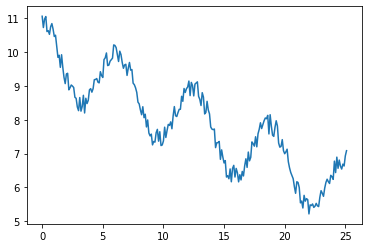

In [2]:
x = np.arange(0,8*np.pi,0.1)
y = 10+np.cos(x)-x/6

# generate noise 
y_noise = []

for i in y:
    n = 0.3
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)

plt.plot(x,y_noise)
plt.show()

## b. Identify the number of periods in a season and then deseasonalize the series. 

### Change x scale into #pi, making observation easier

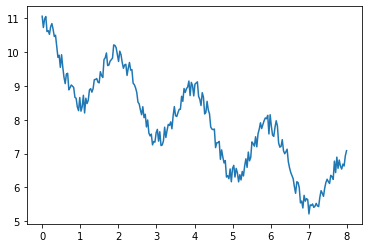

In [3]:
plt.plot(x/np.pi,y_noise)
plt.show()

### As the creator of this time-series, we know that its period is 3.14(by cos()), which means there are 3 interger data points in one period.

### Leading us to assume period roughly close to 3.

<ipython-input-4-ab869889bd6c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)


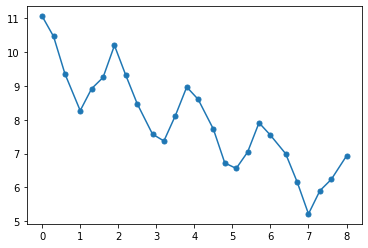

In [4]:
df_original_series = pd.DataFrame({
    'period': x,
    'demand': y_noise
})

# include average interger.
df_interger_series = df_original_series[df_original_series['period'] % 1 == 0]
df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)
plt.plot(df_interger_series['period'],df_interger_series['demand'], marker='o',markersize=5)

# deseasonalize
series_deseasonalization = df_interger_series.loc[:, 'demand'].rolling(3).mean().dropna()
series_deseasonalization=series_deseasonalization.drop([series_deseasonalization.index[22],series_deseasonalization.index[23]])

# deseasonalize dataframe
df_deseasonalization = pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

## c. Calculate the seasonality factors

In [5]:
#build up regressing model
reg = LinearRegression().fit(np.asarray(df_deseasonalization.loc[20:230, 'Period']).reshape(-1, 1),
                            df_deseasonalization.loc[:, 'Deseasonalized_Demand'].dropna())
#predict nan value
values = pd.Series(reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)))

#fill up nan value
df_deseasonalization.loc[0,['Deseasonalized_Demand']] = values[0]
df_deseasonalization.loc[10,['Deseasonalized_Demand']] = values[10]
df_deseasonalization.loc[240,['Deseasonalized_Demand']] = values[24]
df_deseasonalization.loc[250,['Deseasonalized_Demand']] = values[25]

# calculate seansonality factor
df_deseasonalization.loc[:, 'Seasonality'] = (df_deseasonalization.loc[:, 'Demand'] / df_deseasonalization.loc[:, 'Deseasonalized_Demand'])

df_Seasonality_bar= pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

df_seasonality = df_deseasonalization.groupby(['Quater'], as_index=False).mean()
df_seasonality.loc[:, 'Seasonality_bar'] = df_seasonality.loc[:, 'Seasonality']
df_seasonality = df_seasonality[['Quater','Seasonality_bar']]
df_deseasonalization = pd.merge(df_deseasonalization,df_seasonality).sort_values('Period')

In [6]:
df_deseasonalization

,Quater,Period,Demand,Deseasonalized_Demand,Seasonality,Seasonality_bar
0,1,0.0,11.053918,10.119166,1.092374,0.992602
9,2,0.3,10.455796,8.455223,1.236608,1.013624
18,3,0.6,9.349128,10.286280,0.908893,0.979691
1,1,1.0,8.266442,9.357122,0.883439,0.992602
10,2,1.3,8.915853,8.843808,1.008146,1.013624
19,3,1.6,9.245860,8.809385,1.049547,0.979691
2,1,1.9,10.191551,9.451088,1.078347,0.992602
11,2,2.2,9.306449,9.581287,0.971315,1.013624
20,3,2.5,8.466014,9.321338,0.908240,0.979691
3,1,2.9,7.573053,8.448505,0.896378,0.992602


In [7]:
df_seasonality

,Quater,Seasonality_bar
0,1,0.992602
1,2,1.013624
2,3,0.979691


## d. Finalize the model and evaluate the performance via MSE and MAPE

In [8]:
# calulate Forecast, Error, Error_Squre, MSE, MAPE
df_deseasonalization.loc[:, 'Forecast'] =  (reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)) * df_deseasonalization.loc[:, 'Seasonality_bar'])
df_deseasonalization.loc[:, 'Error'] =  (df_deseasonalization.loc[:, 'Demand']-df_deseasonalization.loc[:, 'Forecast'])
df_deseasonalization.loc[:, 'Error_Squre'] =  (df_deseasonalization.loc[:, 'Error']*df_deseasonalization.loc[:, 'Error'])
MSE = df_deseasonalization['Error_Squre'].sum()/len(df_deseasonalization)
MAPE = ((abs(df_deseasonalization.loc[:, 'Error']) / abs(df_deseasonalization.loc[:, 'Demand'])).sum())*100/len(df_deseasonalization)

print("Time-Series Model:")
print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

Time-Series Model:
MSE: 0.524
MAPE: 7.853


## e. Use the static model to predict 𝑦𝑡,𝑡 = 25, … , 30. Use the “true” model to simulate 𝑦25, … , 𝑦30 and calculate the MSE and MAPE accordingly.


### Construct further more data points(y=26~31)

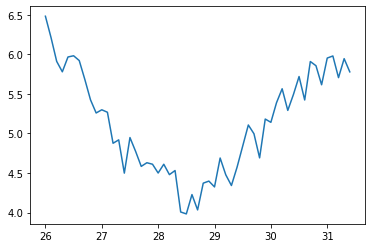

In [9]:
x = np.arange(26.0,10*np.pi,0.1)
y = 10+np.cos(x)-x/6

y_noise = []

for i in y:
    n = 0.3
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)
    
plt.plot(x,y_noise)
plt.show()

### Predicting while using true model

In [10]:
#true model
df_true_model = pd.DataFrame({
    'Period': x,
    'Demand': y_noise,
    'Forecast':y,
})
df_true_model.loc[:, 'Error'] =  (df_true_model.loc[:, 'Demand']-df_true_model.loc[:, 'Forecast'])
df_true_model.loc[:, 'Error_Squre'] =  (df_true_model.loc[:, 'Error']*df_true_model.loc[:, 'Error'])
MSE = df_true_model['Error_Squre'].sum()/len(df_true_model)
MAPE = ((abs(df_true_model.loc[:, 'Error']) / abs(df_true_model.loc[:, 'Demand'])).sum())*100/len(df_true_model)

print("True Model(y=26~31):")
print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

True Model(y=26~31):
MSE: 0.031
MAPE: 3.02


###  Predicting while using constructed model

Time-Series Model(y=26~31):
MSE: 0.536
MAPE: 10.853


<ipython-input-11-c8e5766bbe8b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)


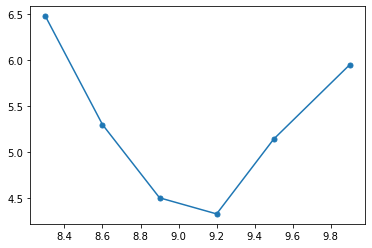

In [11]:
#time-series model
df_time_series_model = pd.DataFrame({   
    'Period': x,
    'Demand': y_noise
})


df_interger_series = df_time_series_model[df_time_series_model['Period'].round(1) % 1.0 == 0]
df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)
plt.plot(df_interger_series['Period'],df_interger_series['Demand'], marker='o',markersize=5)

df_time_series_deseasonalization= pd.DataFrame({   })
df_time_series_deseasonalization = pd.merge(df_interger_series,df_deseasonalization, how="outer").sort_values('Period')
df_time_series_deseasonalization.loc[:,'Quater']=sum([[1,2,3]*10,[1,2]],[])

df_time_series_deseasonalization=df_time_series_deseasonalization.drop(['Seasonality_bar'], axis=1)
df_time_series_deseasonalization = pd.merge(df_time_series_deseasonalization,df_seasonality,how = "outer").sort_values('Period')

df_time_series_deseasonalization.loc[:, 'Forecast'] =  (reg.predict(np.asarray(df_time_series_deseasonalization.loc[:, 'Period']).reshape(-1,1)) * df_time_series_deseasonalization.loc[:, 'Seasonality_bar'])
df_time_series_deseasonalization.loc[:, 'Error'] =  (df_time_series_deseasonalization.loc[:, 'Demand']-df_time_series_deseasonalization.loc[:, 'Forecast'])
df_time_series_deseasonalization.loc[:, 'Error_Squre'] =  (df_time_series_deseasonalization.loc[:, 'Error']*df_time_series_deseasonalization.loc[:, 'Error'])
MSE = df_time_series_deseasonalization['Error_Squre'].sum()/len(df_time_series_deseasonalization)
MAPE = ((abs(df_time_series_deseasonalization.loc[:, 'Error']) / abs(df_time_series_deseasonalization.loc[:, 'Demand'])).sum())*100/len(df_deseasonalization)

print("Time-Series Model(y=26~31):")
print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

## f. Modify the disturbance in (a) to change series (can be more or less fluctuating). Re-run the questions (b)-(d). What can you conclude when comparing to the results in (d) with the previous disturbance.

### Change noise factor from 0.3 to 0.1.

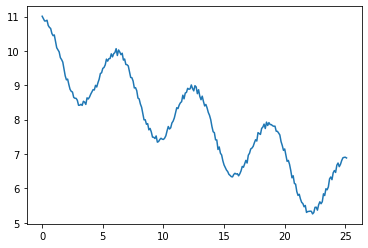

In [12]:
x = np.arange(0,8*np.pi,0.1)
y = 10+np.cos(x)-x/6

y_noise = []

for i in y:
    n = 0.1
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)

plt.plot(x,y_noise)
plt.show()

<ipython-input-13-ab869889bd6c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)


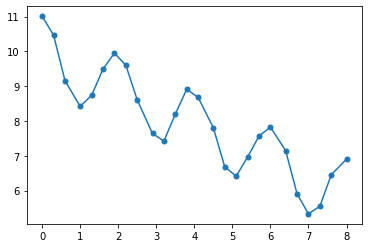

In [13]:
df_original_series = pd.DataFrame({
    'period': x,
    'demand': y_noise
})

# include average interger.
df_interger_series = df_original_series[df_original_series['period'] % 1 == 0]
df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)
plt.plot(df_interger_series['period'],df_interger_series['demand'], marker='o',markersize=5)

# deseasonalize
series_deseasonalization = df_interger_series.loc[:, 'demand'].rolling(3).mean().dropna()
series_deseasonalization=series_deseasonalization.drop([series_deseasonalization.index[22],series_deseasonalization.index[23]])

# deseasonalize dataframe
df_deseasonalization = pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

In [14]:
#build up regressing model
reg = LinearRegression().fit(np.asarray(df_deseasonalization.loc[20:230, 'Period']).reshape(-1, 1),
                            df_deseasonalization.loc[:, 'Deseasonalized_Demand'].dropna())
#predict nan value
values = pd.Series(reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)))

df_deseasonalization.loc[0,['Deseasonalized_Demand']] = values[0]
df_deseasonalization.loc[10,['Deseasonalized_Demand']] = values[10]
df_deseasonalization.loc[240,['Deseasonalized_Demand']] = values[24]
df_deseasonalization.loc[250,['Deseasonalized_Demand']] = values[25]

# calculate seansonality factor
df_deseasonalization.loc[:, 'Seasonality'] = (df_deseasonalization.loc[:, 'Demand'] / df_deseasonalization.loc[:, 'Deseasonalized_Demand'])

df_Seasonality_bar= pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

df_seasonality = df_deseasonalization.groupby(['Quater'], as_index=False).mean()
df_seasonality.loc[:, 'Seasonality_bar'] = df_seasonality.loc[:, 'Seasonality']
df_seasonality = df_seasonality[['Quater','Seasonality_bar']]

df_deseasonalization = pd.merge(df_deseasonalization,df_seasonality).sort_values('Period')

In [15]:
df_deseasonalization.loc[:, 'Forecast'] =  (reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)) * df_deseasonalization.loc[:, 'Seasonality_bar'])
df_deseasonalization.loc[:, 'Error'] =  (df_deseasonalization.loc[:, 'Demand']-df_deseasonalization.loc[:, 'Forecast'])
df_deseasonalization.loc[:, 'Error_Squre'] =  (df_deseasonalization.loc[:, 'Error']*df_deseasonalization.loc[:, 'Error'])
MSE = df_deseasonalization['Error_Squre'].sum()/len(df_deseasonalization)
MAPE = ((abs(df_deseasonalization.loc[:, 'Error']) / abs(df_deseasonalization.loc[:, 'Demand'])).sum())*100/len(df_deseasonalization)

print("Time-Series Model(less disturbance):")
print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

Time-Series Model(less disturbance):
MSE: 0.546
MAPE: 8.679


### In this disturbance data simulation, we have better performance in both MSE and MAPE than previous model

# Q2

### rearrange the data

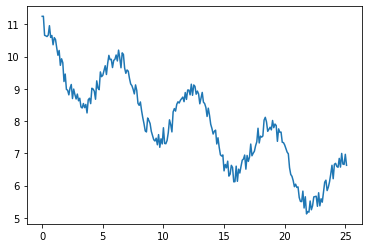

In [16]:
x = np.arange(0,8*np.pi,0.1)
y = 10+np.cos(x)-x/6

y_noise = []

for i in y:
    n = 0.3
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)

plt.plot(x,y_noise)
plt.show()

<ipython-input-17-e09ded7e73c9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)


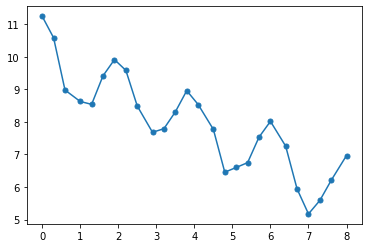

In [17]:
df_original_series = pd.DataFrame({
    'Period': x,
    'Demand': y_noise
})

# include average interger.
df_interger_series = df_original_series[df_original_series['Period'] % 1 == 0]
df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)
plt.plot(df_interger_series['Period'],df_interger_series['Demand'], marker='o',markersize=5)


In [18]:
# train the data with Holt-Winters algorithms with statsmodels module.
HWES_model = HWES(df_interger_series.loc[:, 'Demand'], seasonal_periods=3, trend='add', seasonal='mul')
HWES_fit_report = HWES_model.fit()
print(HWES_fit_report.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Demand   No. Observations:                   26
Model:             ExponentialSmoothing   SSE                             13.224
Optimized:                         True   AIC                             -3.578
Trend:                         Additive   BIC                              5.229
Seasonal:                Multiplicative   AICC                             7.672
Seasonal Periods:                     3   Date:                 Sun, 10 Oct 2021
Box-Cox:                          False   Time:                         22:34:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

C:\Users\TerryYang\anaconda3\envs\TENSORFLOW\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\TerryYang\anaconda3\envs\TENSORFLOW\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
